In [1]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import interpolate
from operator import itemgetter
import matplotlib as mpl
from astropy.stats import sigma_clip
from scipy.stats import iqr

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Optimal Lowercut Method: Shifting the Most Precise Lowercut Measurement

The lowercut value appears to be key to TAME assigning a good equivalent width measurement for a given line. This notebook uses measurements taken from ~40 stars at 10 different lowercut values to find the best lowercut value per line. Prior to this method, we've been attempting to find the optimal lowercut value as the value where the typical (or average) percent difference with respect to our known values is minimized. We've found that the solution space for these measurements can be broad and certain solutions have large spread. Therefore, this notebook explores a different approach. We select the optimal lowercut value as the value where the spread in percent different is minimized and apply an offset to get the percent difference of that lowercut value centered on zero.

In [2]:
# Select Datasets and extract equivalent widths
outputs = glob.glob("tame-1.1.0/*sm1.json")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'JSON File': outputs, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)
disp_df

,By-Hand File,JSON File
0,tame-1.1.0/col110_1134red_oned_25jan14.ew,tame-1.1.0/col110_1134red_oned_25jan14_sm1.json
1,tame-1.1.0/col110_2119red_oned_26jan14.ew,tame-1.1.0/col110_2119red_oned_26jan14_sm1.json
2,tame-1.1.0/col110_2129red_oned_25jan14.ew,tame-1.1.0/col110_2129red_oned_25jan14_sm1.json
3,tame-1.1.0/col110_2223red_oned_26jan14.ew,tame-1.1.0/col110_2223red_oned_26jan14_sm1.json
4,tame-1.1.0/col110_3122red_oned_mar2014.ew,tame-1.1.0/col110_3122red_oned_mar2014_sm1.json
5,tame-1.1.0/col110_3144red_oned_mar2014.ew,tame-1.1.0/col110_3144red_oned_mar2014_sm1.json
6,tame-1.1.0/col110_3244red_oned_25jan14.ew,tame-1.1.0/col110_3244red_oned_25jan14_sm1.json
7,tame-1.1.0/col110_4260red_oned_26jan14.ew,tame-1.1.0/col110_4260red_oned_26jan14_sm1.json
8,tame-1.1.0/col110_5125red_oned_26jan14.ew,tame-1.1.0/col110_5125red_oned_26jan14_sm1.json
9,tame-1.1.0/ngc2204_1124red_oned_05jan14.ew,tame-1.1.0/ngc2204_1124red_oned_05jan14_sm1.json


[-9.5500000000000043, -8.7499999999999929, -8.25, -8.0500000000000043, -7.1999999999999886, -5.2999999999999972, -3.7000000000000028, -2.3999999999999915, -1.1499999999999986, -0.60000000000000853]
5234.63
0.995 3.975
[14.924999999999994, 13.274999999999991, 12.75, 12.225000000000009, 10.799999999999983, 7.9499999999999957, 5.6999999999999957, 4.3500000000000085, 4.875, 3.9750000000000085]


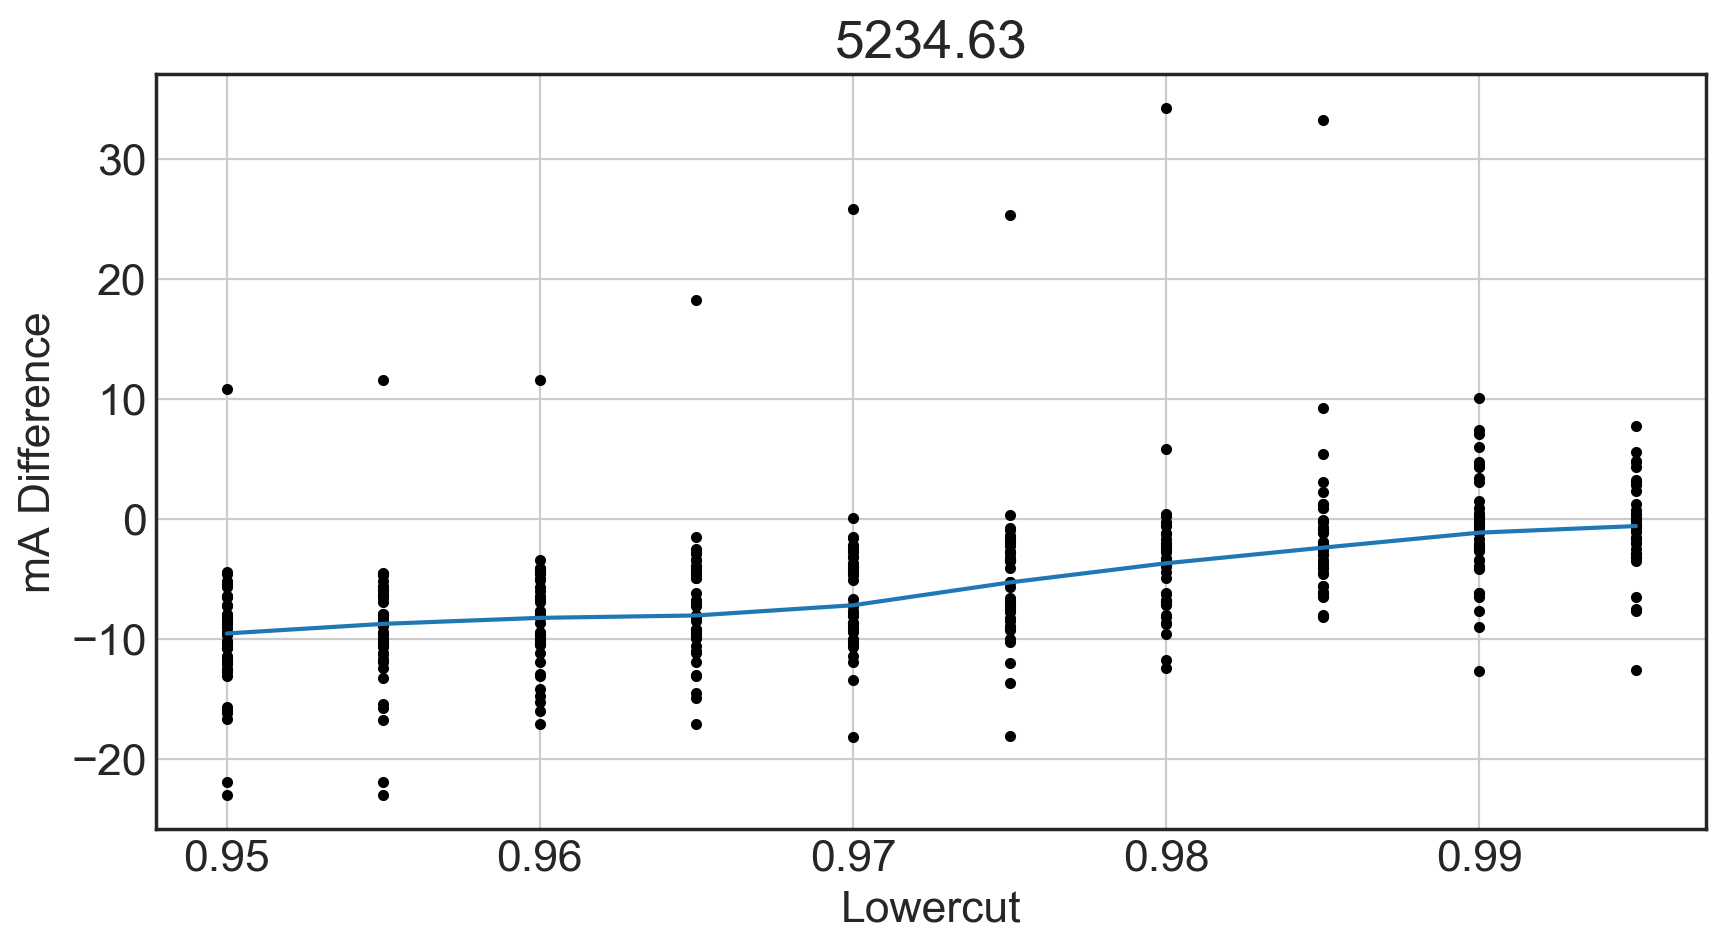

In [8]:
# Find optimal lowercut value
write_out = False
plot = True

with open(outputs[0]) as jsonfile:
    jsondata = json.load(jsonfile)
    key = list(jsondata.keys())[2]
    lowcuts = [cut for cut,ew in jsondata[key]]
    line_list = list(jsondata.keys())
    line_list = np.array(sorted(np.array(line_list).astype(float))).astype(str)

if write_out:
    f_out = open("as.txt","w")
solns_dev = []
closest_dev = []
closest_pdiffs = []

line_dict = {}
for line in line_list[0:1]:
    if plot:
        plt.figure(figsize=(10,5), dpi = 200)
        plt.grid()
    pdiff_all = []
    hand_all = []
    for i in range(len(outputs)):
        if 'ngc2204_3321red' in outputs[i]:
            continue
        with open(outputs[i]) as jsonfile, open(by_hand[i]) as ewfile:
            jsondata = json.load(jsonfile)
            handdata = pd.read_csv(ewfile, delim_whitespace = True, header = None)[[0,4]]
            hand_dict = dict(zip([str(i) for i in handdata[0].tolist()], handdata[4].tolist()))
            key = line
            lowercut = [cut for cut,ew in jsondata[key]]
            ew_meas = [ew for cut,ew in jsondata[key]]
            #print(outputs[i])
            #print(ew_meas)
            #print(hand_dict[key])
            
            label = disp_df['JSON File'][i].split('/')[-1].split('.')[0]
            if hand_dict[key] == 0:
                continue
            if len(lowercut) < len_range:
                continue
            
            ew_pdiff = ((np.array(ew_meas)-hand_dict[key])/hand_dict[key]) * 100
            ew_absdiff = np.array(ew_meas) - hand_dict[key]
            #plt.plot(lowercut,ew_pdiff,'.',color='k')
            pdiff_all.append(ew_absdiff)
            hand_all.append(hand_dict[key])
    

    pdiff_all = np.array(pdiff_all,dtype='object').T
    #print(hand_all)
    
    #Sigma Clip
    sigma = 5
    pdiff_sclip = [np.ma.compressed(sigma_clip(np.array(pdiff_all[lowcuts.index(lc_val)]).astype(float),sigma=sigma)) 
                   for lc_val in lowcuts]
    #print(len(pdiff_all))
    if plot:
        for pdiff in np.array(pdiff_all).T:
            plt.plot(lowcuts,pdiff,'.',color='k')
    avg_pdiffs = [np.median(pdiff_sclip[lowcuts.index(lc_val)]) for lc_val in lowcuts]
    std_pdiffs = [np.median(abs(pdiff_sclip[lowcuts.index(lc_val)])) * 1.5 for lc_val in lowcuts] # median of abs value of the diff
    #std_pdiffs = [iqr(pdiff_sclip[lowcuts.index(lc_val)]) for lc_val in lowcuts] # interquartile range
    #std_pdiffs = [np.std(pdiff_sclip[lowcuts.index(lc_val)]) for lc_val in lowcuts]  # standard deviation 
    
    if plot:
        plt.plot(lowcuts, avg_pdiffs)

    best_lowcut = lowcuts[np.argmin(std_pdiffs)] #Best lowcut is solution with smallest spread (not solution that has the closest percent difference)
    #pdiff_offset = avg_pdiffs[np.argmin(std_pdiffs)] # The mean percent difference associated with the chosen lowcut value is the offset value
    pdiff_offset = avg_pdiffs
    print(pdiff_offset)
    if plot:
        plt.title(line)
        plt.xlabel("Lowercut")
        plt.ylabel("mA Difference")
        print("======")
        print(line)
        print(best_lowcut, np.min(std_pdiffs))
        print(std_pdiffs)
        if np.min(std_pdiffs) > 10:
            print("WARNING: Large Standard Deviation, Bimodal?")
    
    line_dict[line] = (best_lowcut, np.min(std_pdiffs), pdiff_offset,np.mean(hand_all))
if write_out:
    f_out.close()
    

7.65
3.0375


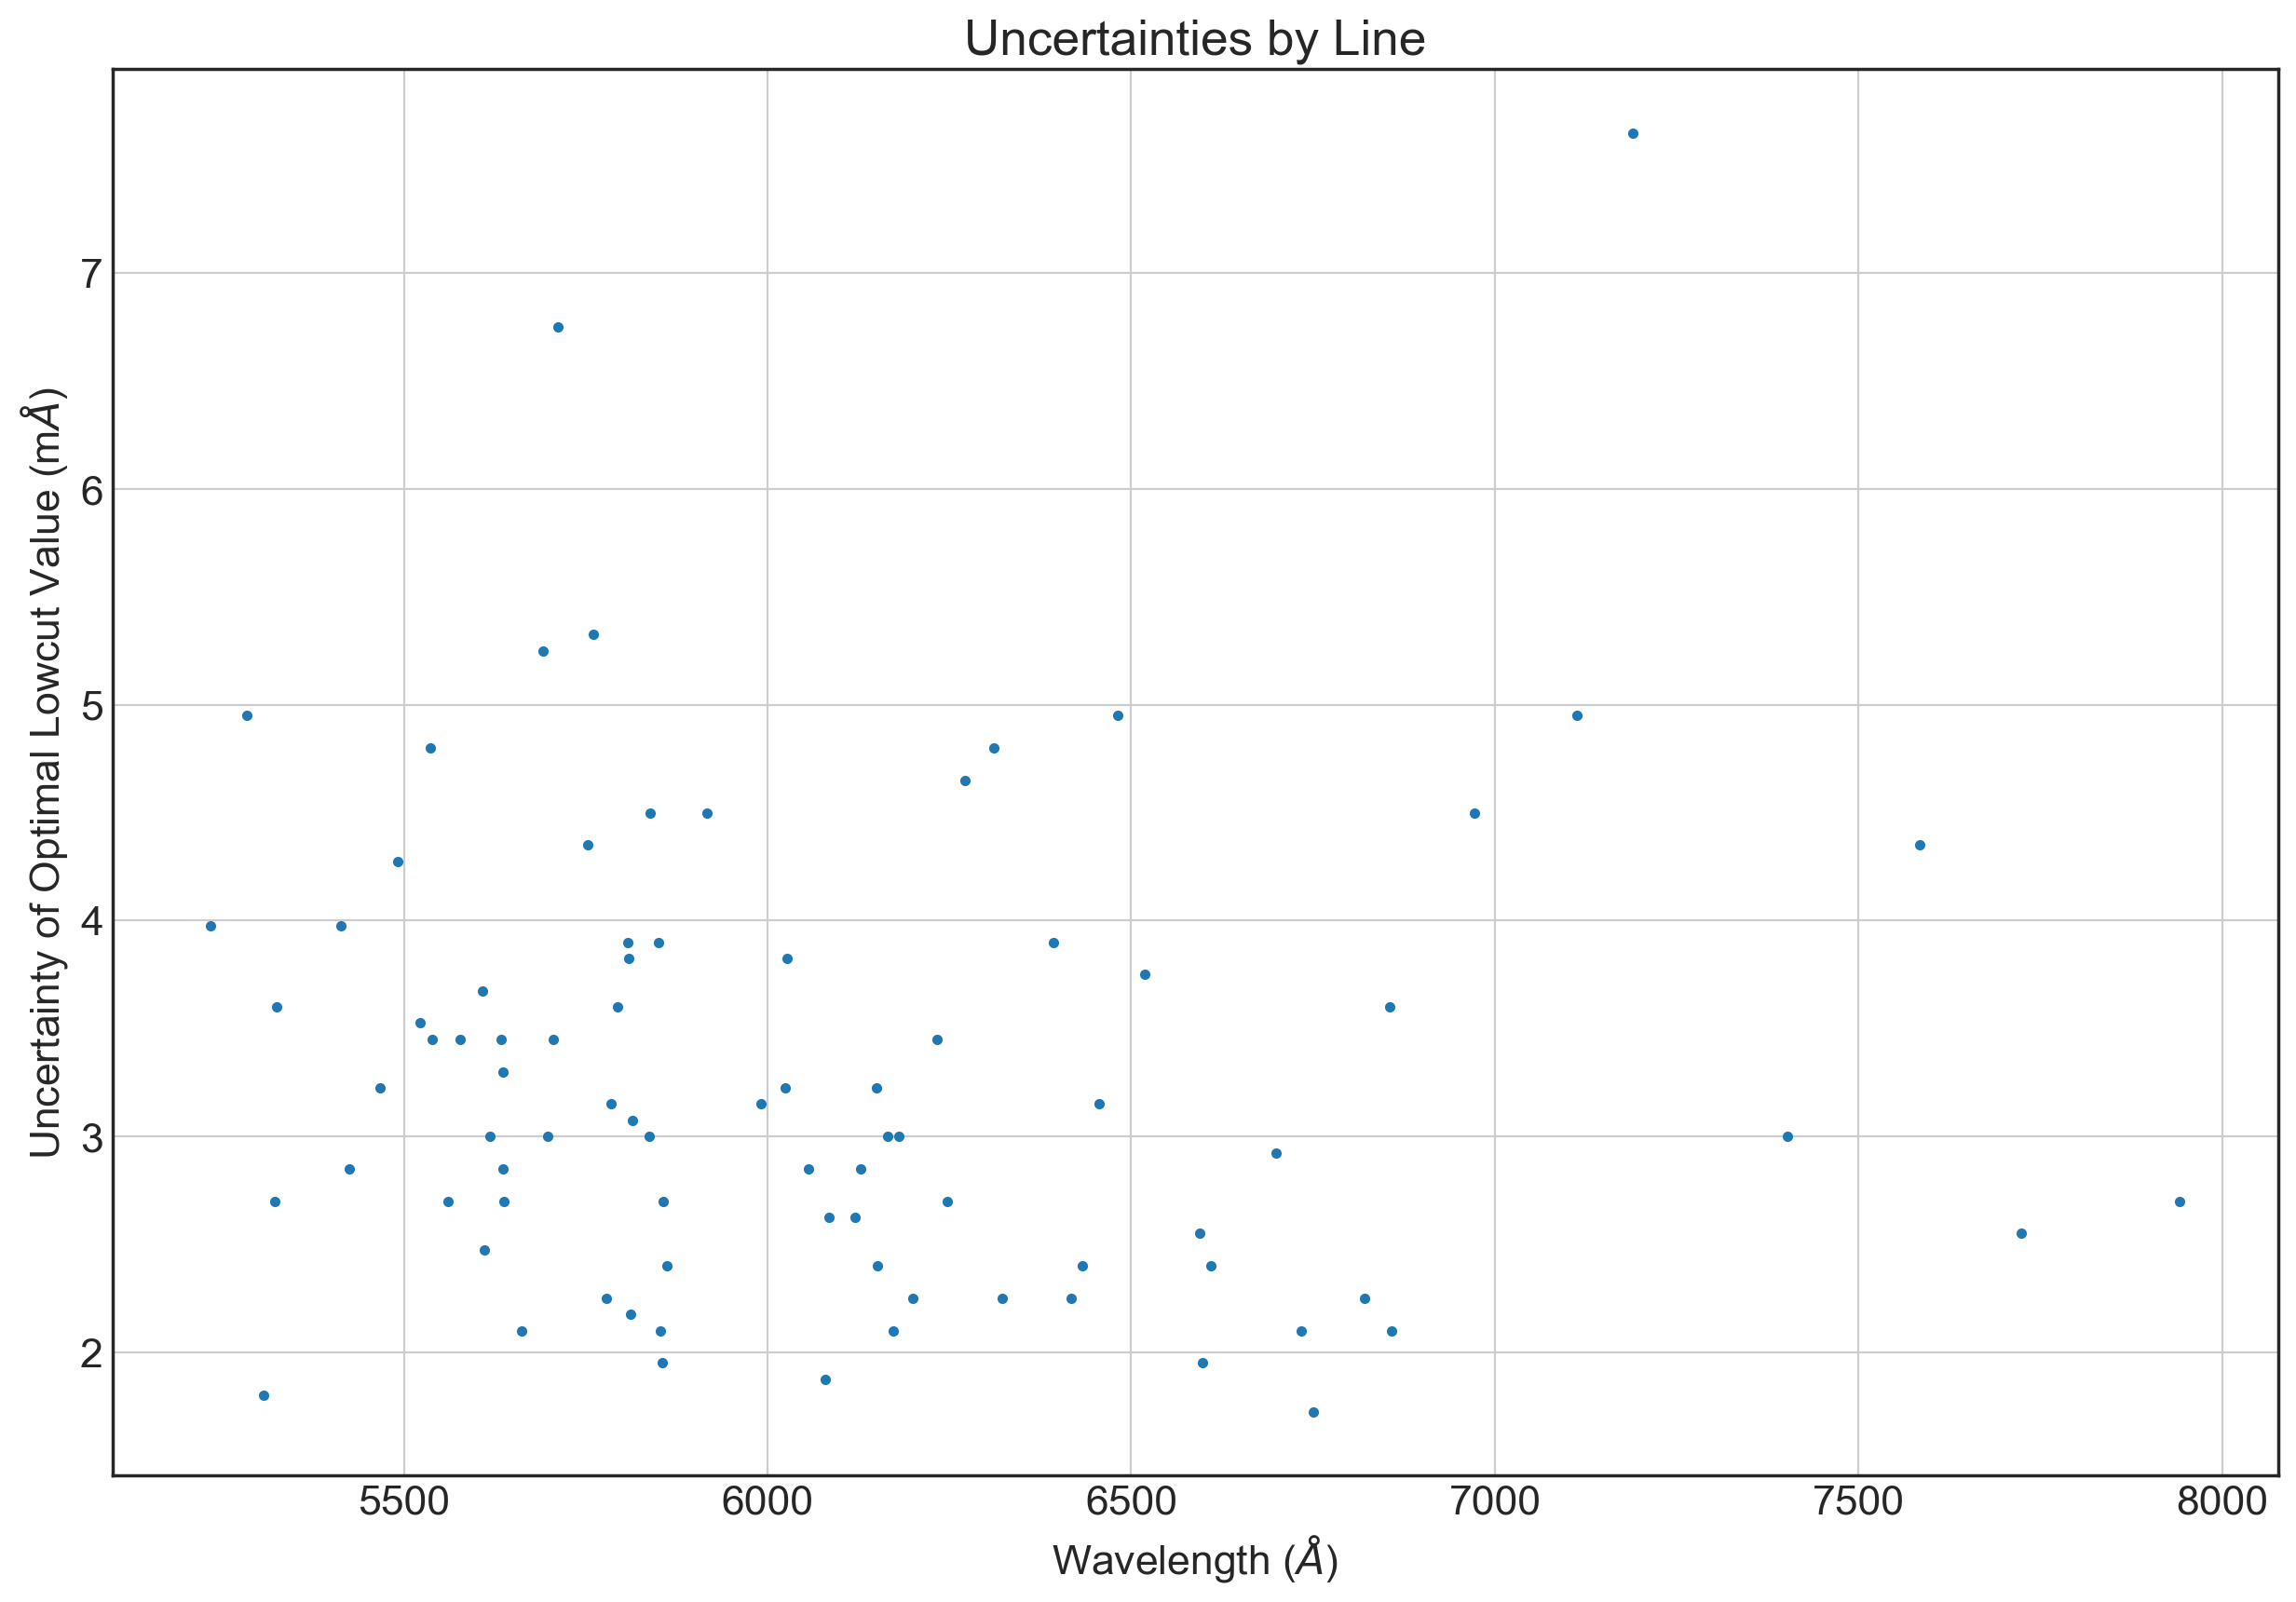

In [165]:
#print(list(line_dict.keys()))
opt_vals = [line_dict.get(key)[0] for key in line_dict.keys()]
val_unc = [line_dict.get(key)[1] for key in line_dict.keys()]
val_offst = [line_dict.get(key)[2] for key in line_dict.keys()]
hand_meas = [line_dict.get(key)[3] for key in line_dict.keys()]
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200
print(max(val_unc))
plt.plot(list(line_dict.keys()),val_unc,'.')
plt.title("Uncertainties by Line")
plt.ylabel(r"Uncertainty of Optimal Lowcut Value (m$\AA$)")
#plt.ylabel("Standard Deviation of Optimal Lowcut Value (%)")
plt.xlabel(r"Wavelength ($\AA$)")
print(np.median(val_unc))

#plt.savefig("absdiff_uncs.png")

#Table instead

[ 2.91       3.709875   4.5838125  4.82575    7.253025 ]


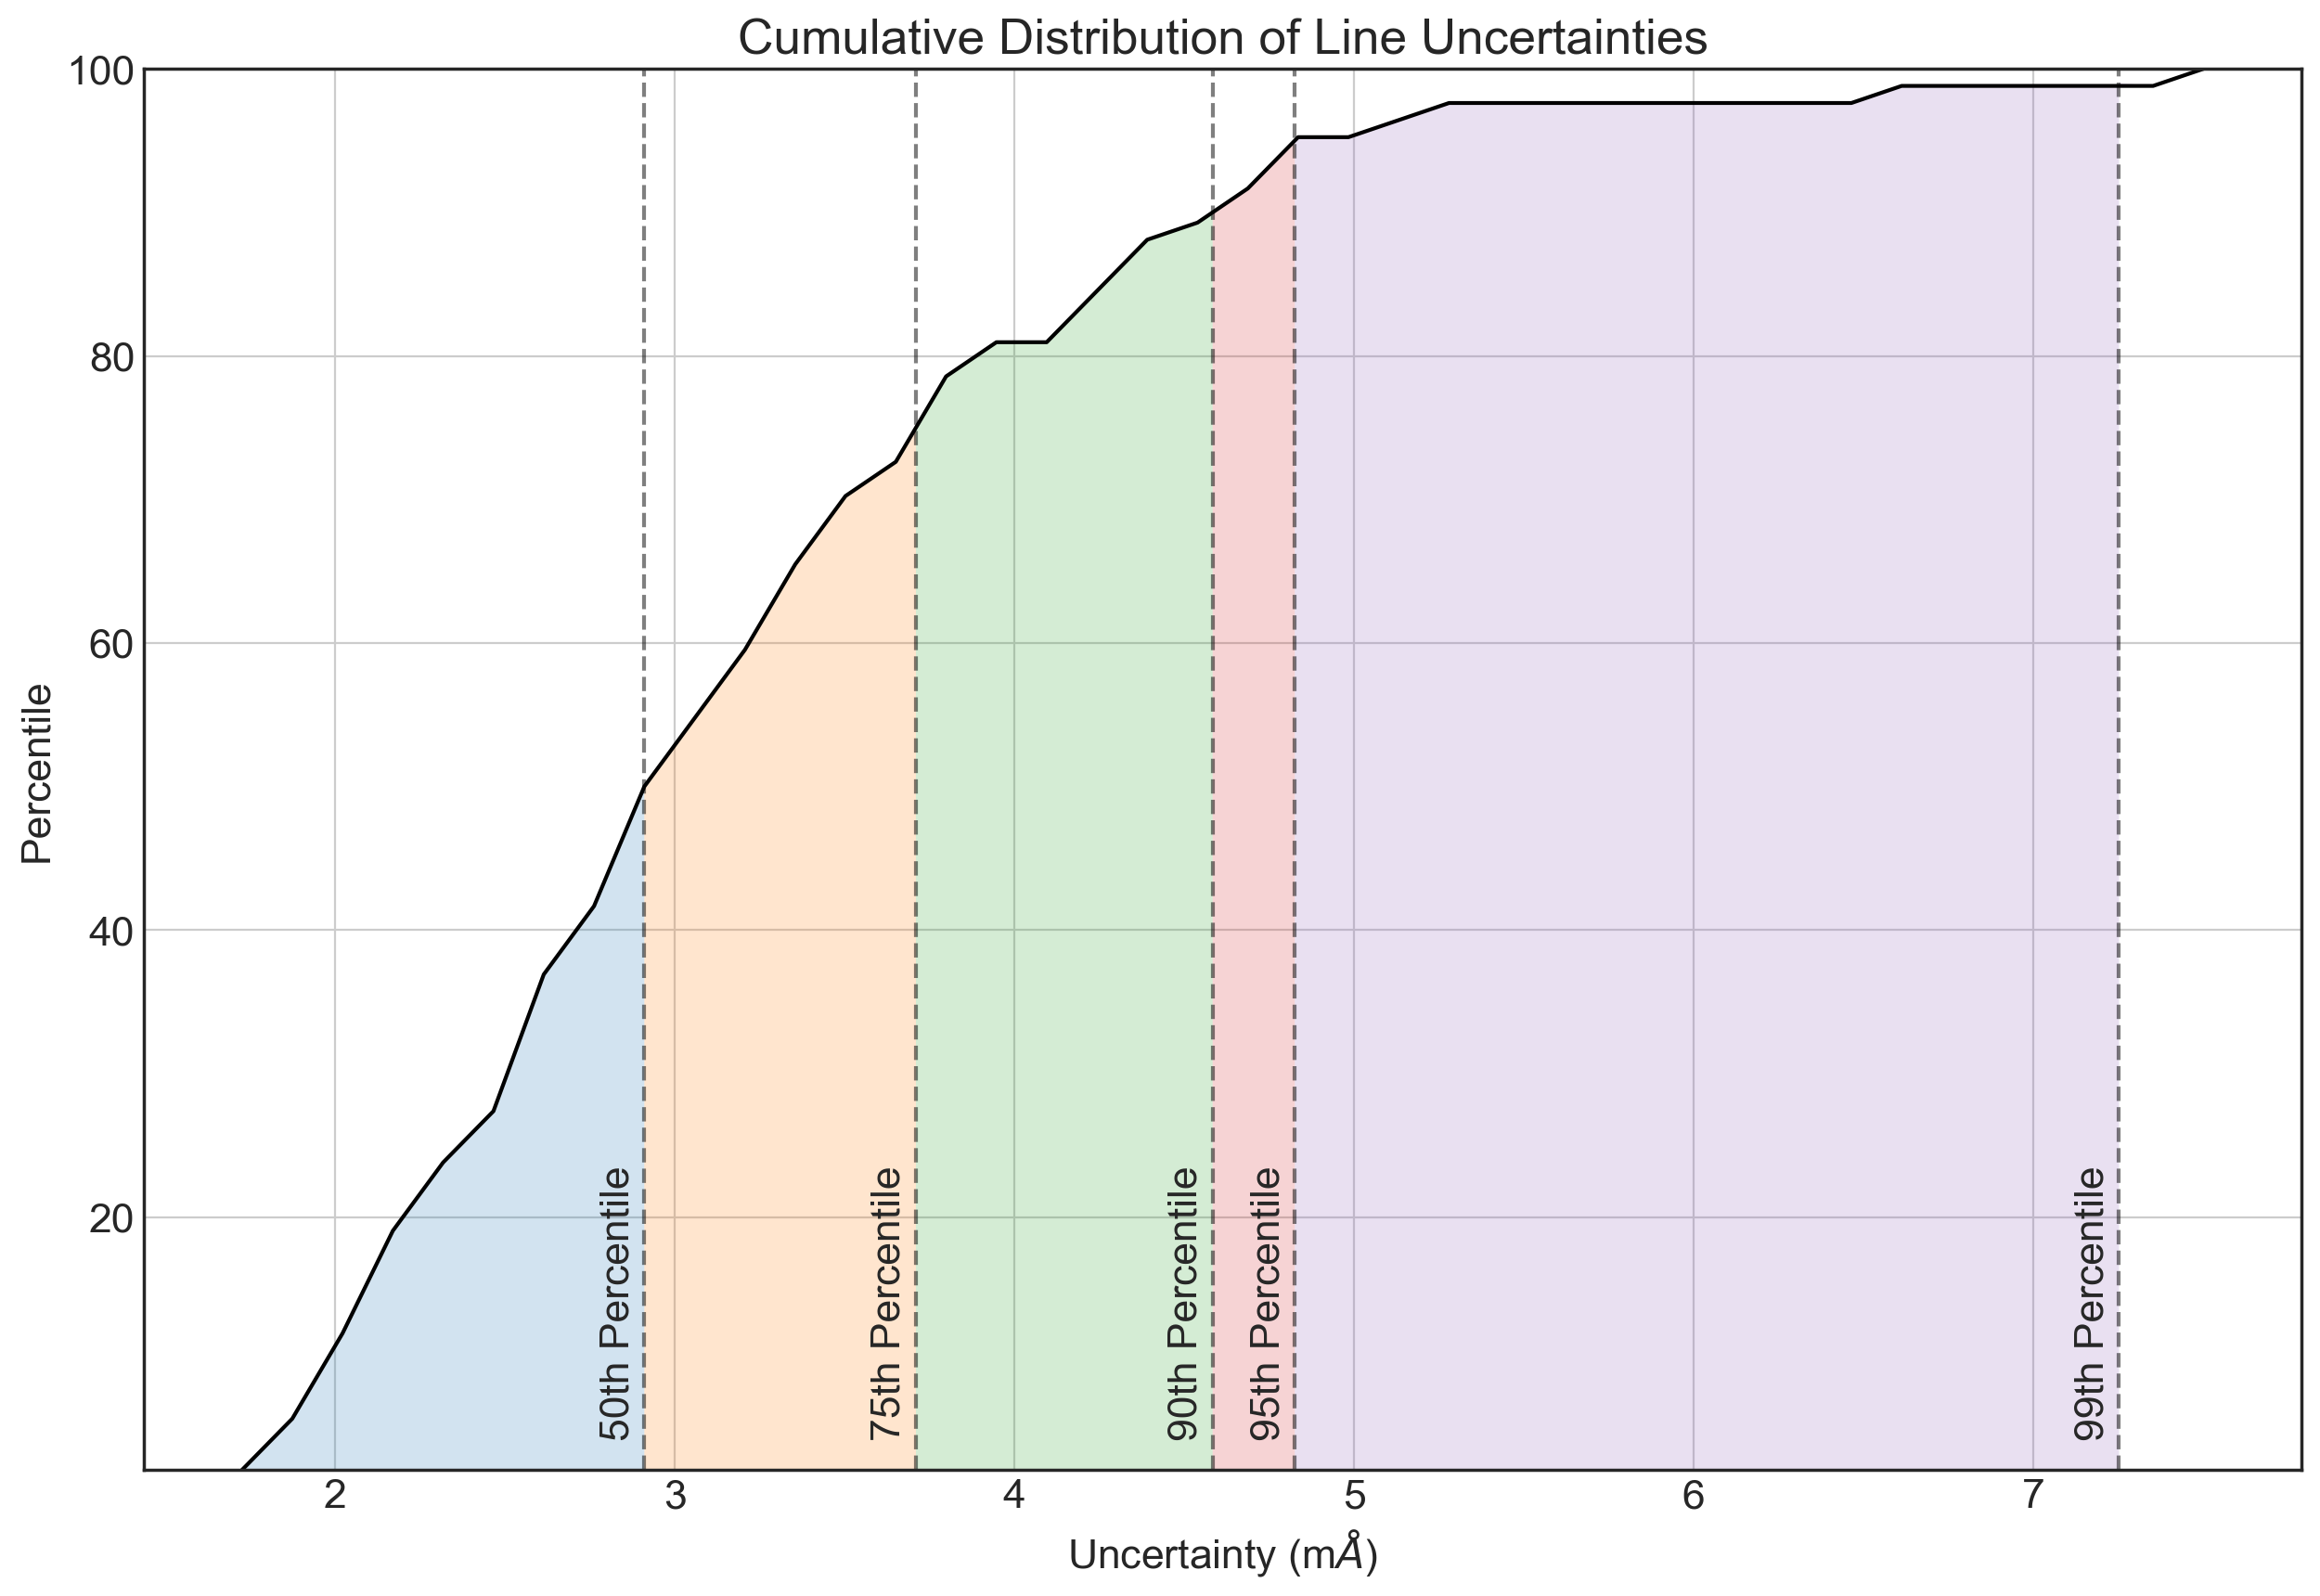

In [204]:
fig, ax = plt.subplots(1,1,figsize=(15,10),dpi = 200)
ax.grid()

unc_values, unc_base = np.histogram(val_unc, bins=40)

#evaluate the cumulative
unc_cumulative = np.cumsum(unc_values)
percentile = unc_cumulative/len(val_unc)*100
p_vals = [50,75,90,95,99]
p_unc = np.interp(p_vals, percentile, unc_base[:-1], period=360)
print(p_unc)

# plot the cumulative function
ax.plot(unc_base[:-1], percentile, c='k',label = "Line Uncertainties")
ax.set_title("Cumulative Distribution of Line Uncertainties")
ax.set_ylabel("Percentile")
ax.set_xlabel(r"Uncertainty (m$\AA$)")
ax.set_ylim(min(percentile), 100)
#ax.set_xlim(0, max(val_unc) + 1)

last_val = 0
last_unc = min(percentile)
for val,unc in zip(p_vals,p_unc):
    ax.axvline(unc, linestyle = '--', color = 'k', alpha =0.5)
    p_mask = (percentile < val) * (percentile > last_val)
    unc_reg = np.append(unc_base[:-1][p_mask],unc) 
    p_reg = np.append(percentile[p_mask],val)
    unc_reg = np.append(np.array([last_unc]), unc_reg)
    p_reg = np.append(np.array([last_val]), p_reg)
    
    ax.fill_between(unc_reg,0,p_reg,alpha = 0.2)
    ax.text(unc - 0.010*max(val_unc), 14, '{}th Percentile'.format(val), horizontalalignment='center', 
             verticalalignment='center', transform=ax.transData, rotation = 90)
    last_val = val
    last_unc = unc
    

#plt.xlabel(r"Uncertainty (%)")

plt.savefig("paper_cumdist.png")

#Journal with tweaks?

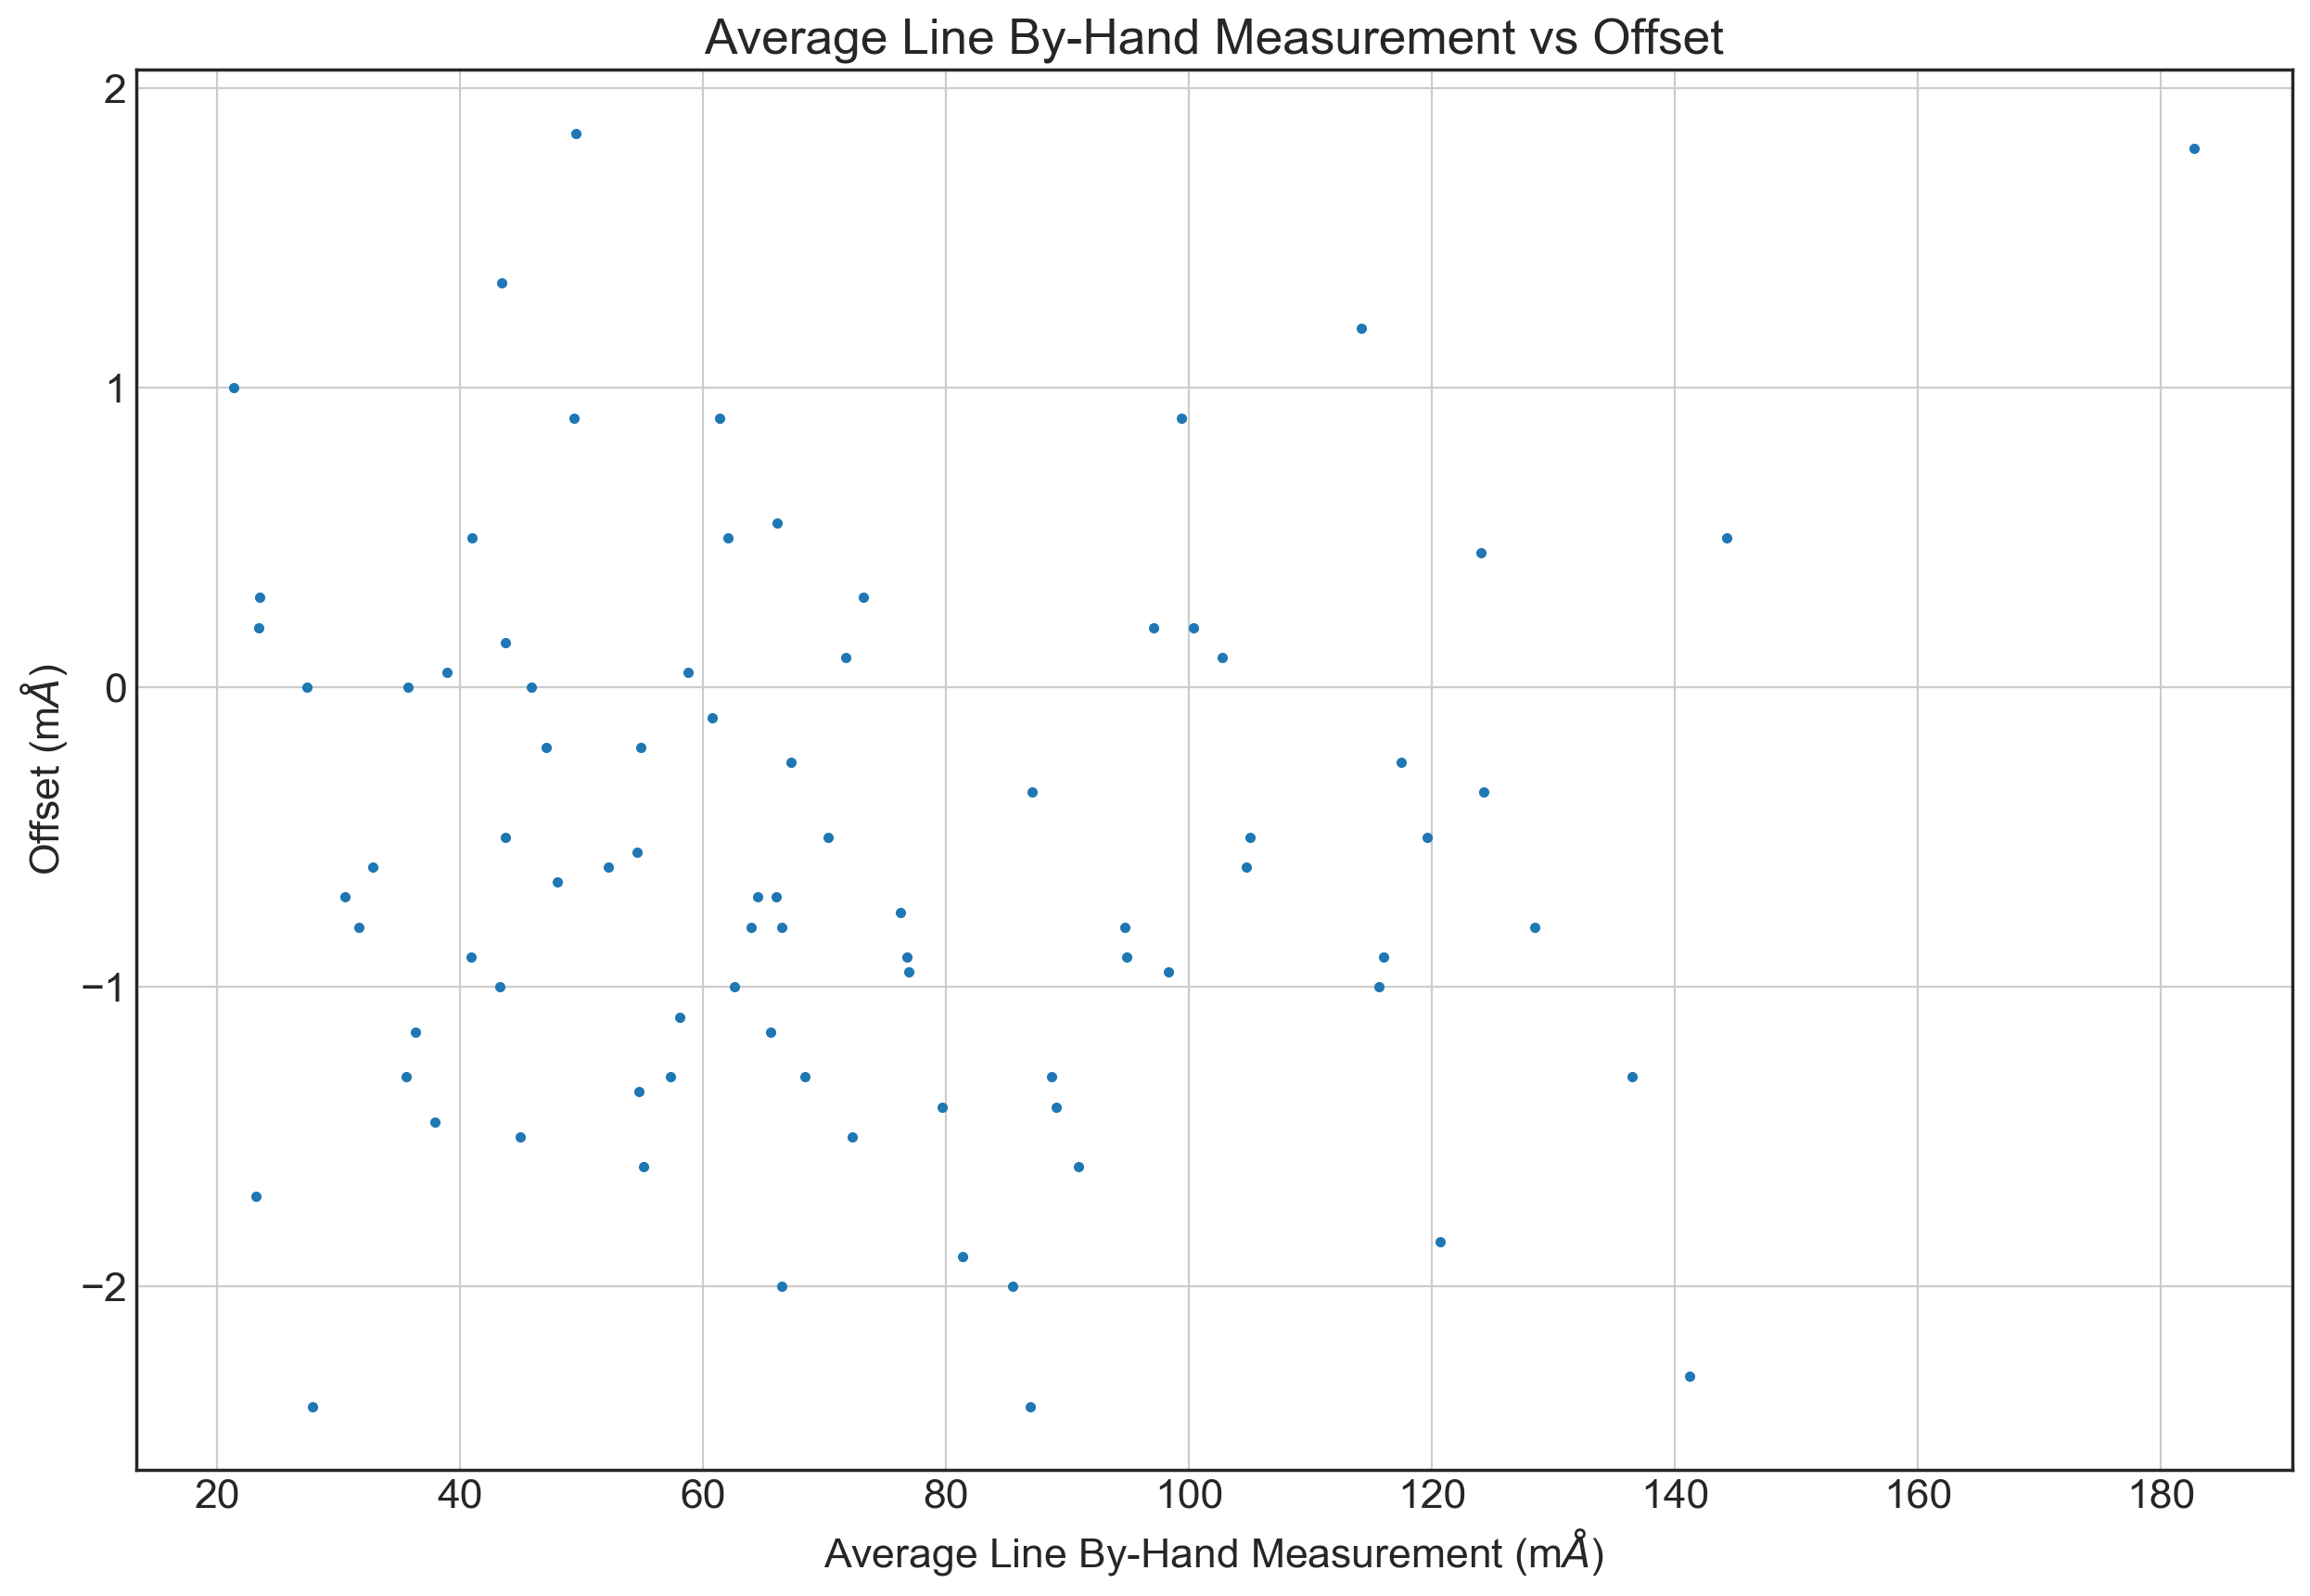

In [207]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(hand_meas, val_offst, '.')
plt.title("Average Line By-Hand Measurement vs Offset")
plt.ylabel(r"Offset (m$\AA$)")
plt.xlabel(r"Average Line By-Hand Measurement (m$\AA$)")

#plt.savefig("abs_offset_vs_ew.png")

#Journal?

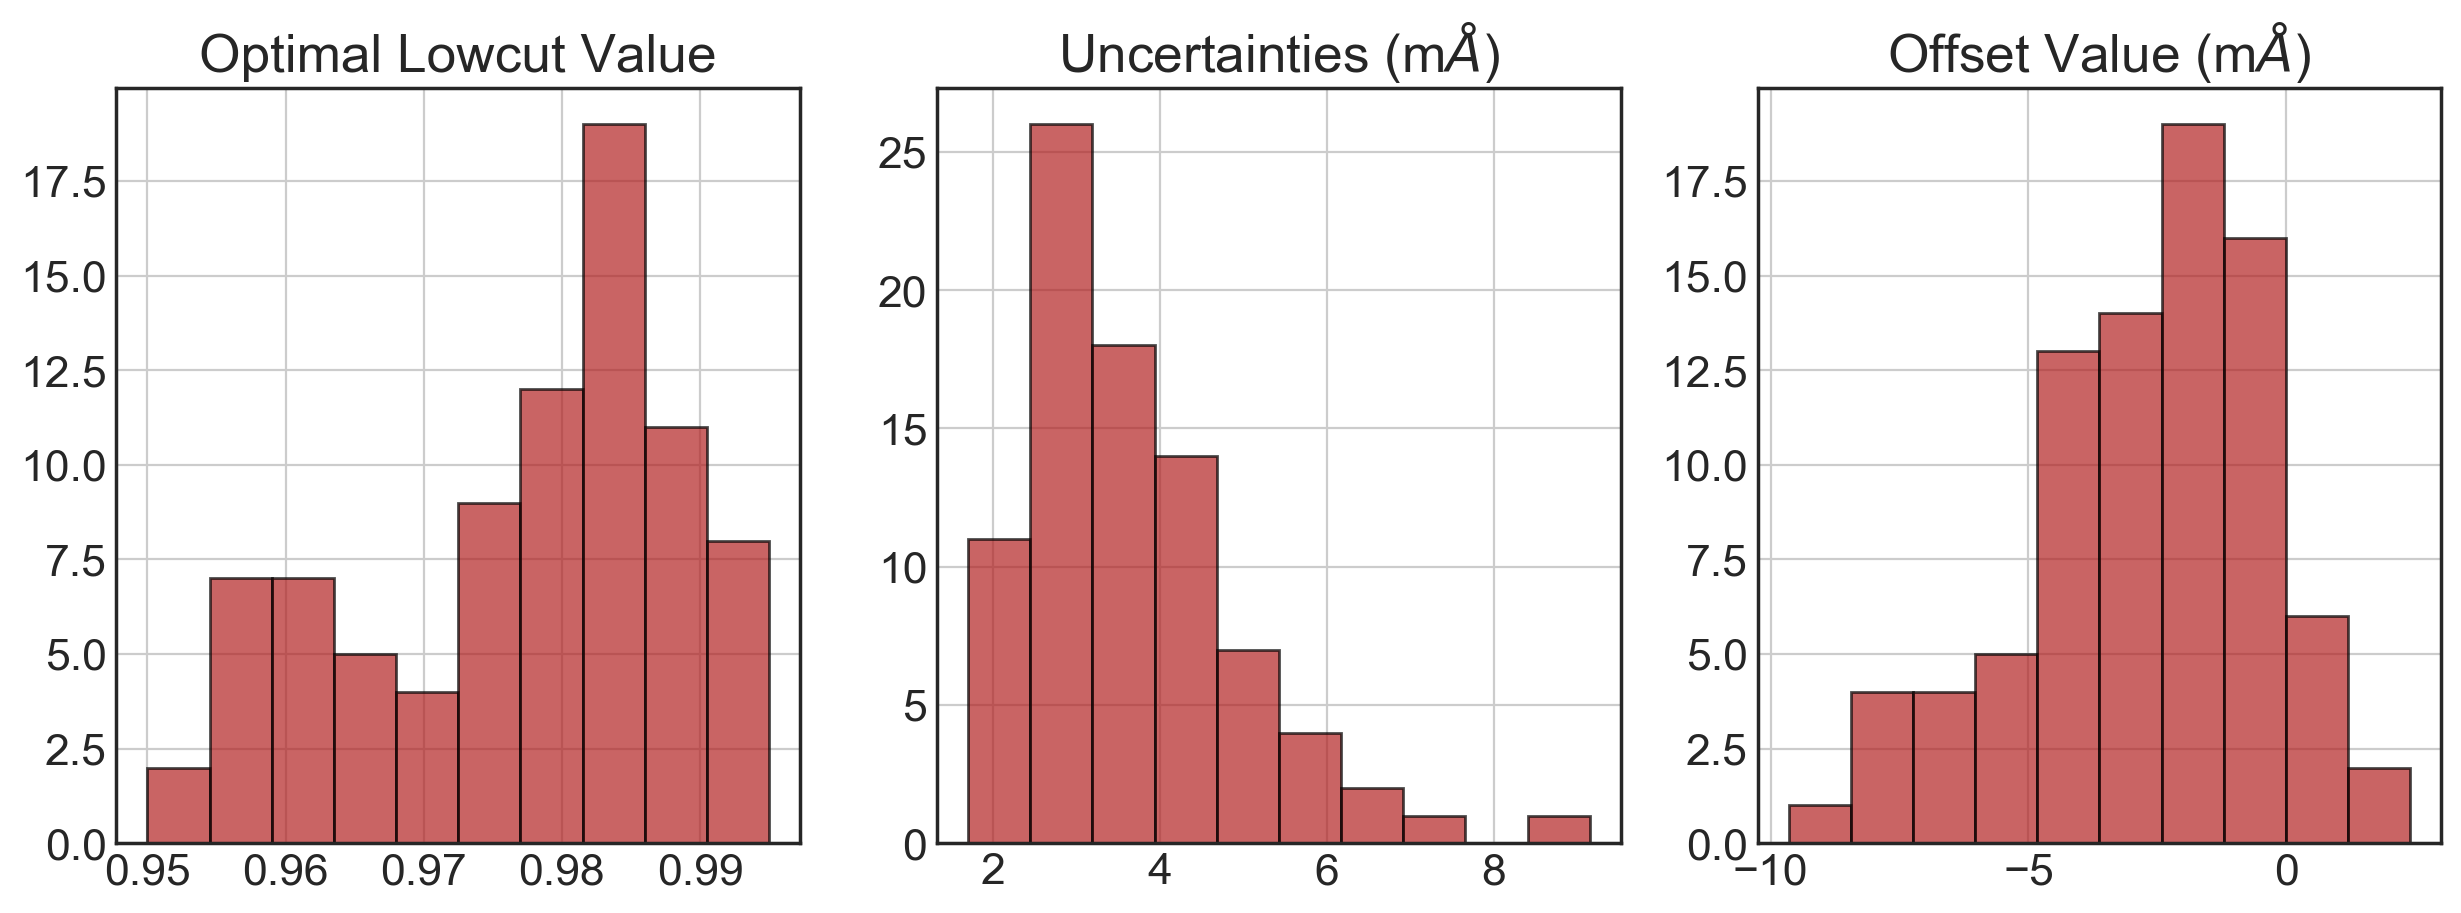

In [163]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5),dpi=200)

ax1.hist(opt_vals,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=10)
ax1.set_title("Optimal Lowcut Value")
ax1.grid()

ax2.hist(val_unc,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=10)
ax2.set_title(r"Uncertainties (m$\AA$)")
#ax2.set_xlim(0,20)
ax2.grid()

ax3.hist(val_offst,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=10)
ax3.set_title(r"Offset Value (m$\AA$)")
ax3.grid()

In [136]:
# Distribution of by-hand measurements

#plt.hist(hand_meas,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=30)

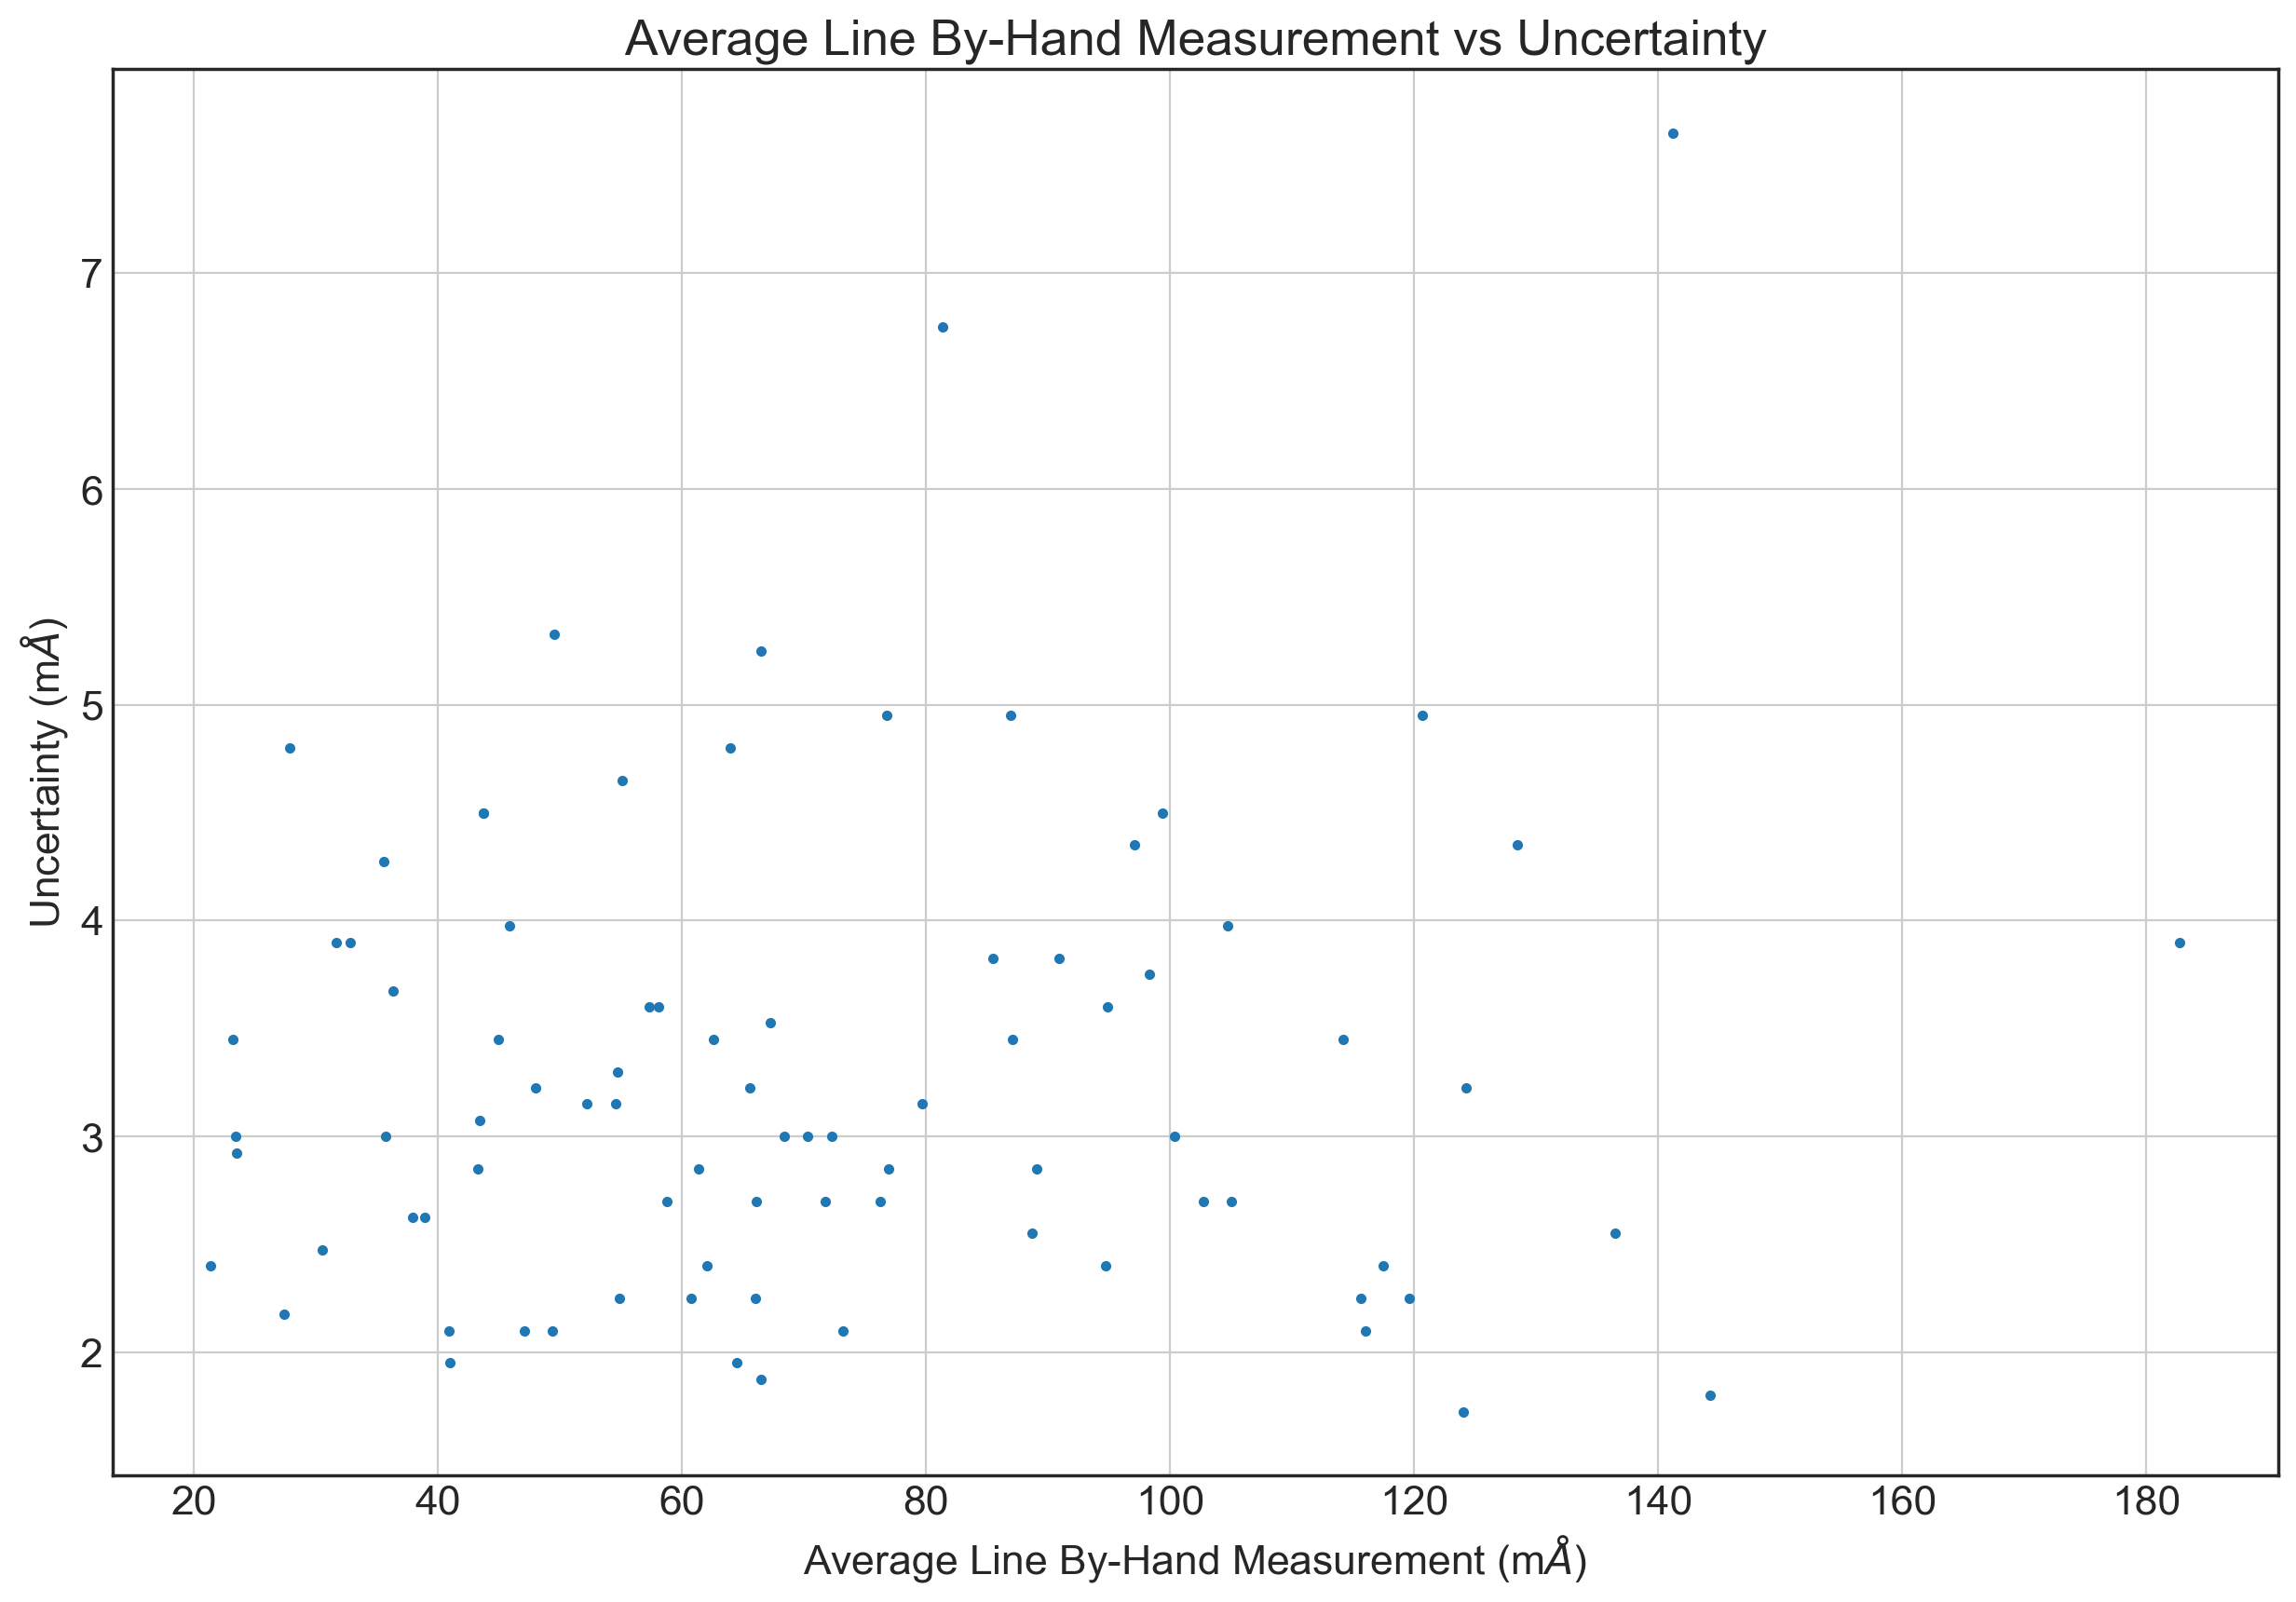

In [208]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(hand_meas, val_unc, '.')
plt.title("Average Line By-Hand Measurement vs Uncertainty")
plt.ylabel(r"Uncertainty (m$\AA$)")
plt.xlabel(r"Average Line By-Hand Measurement (m$\AA$)")

#Journal?

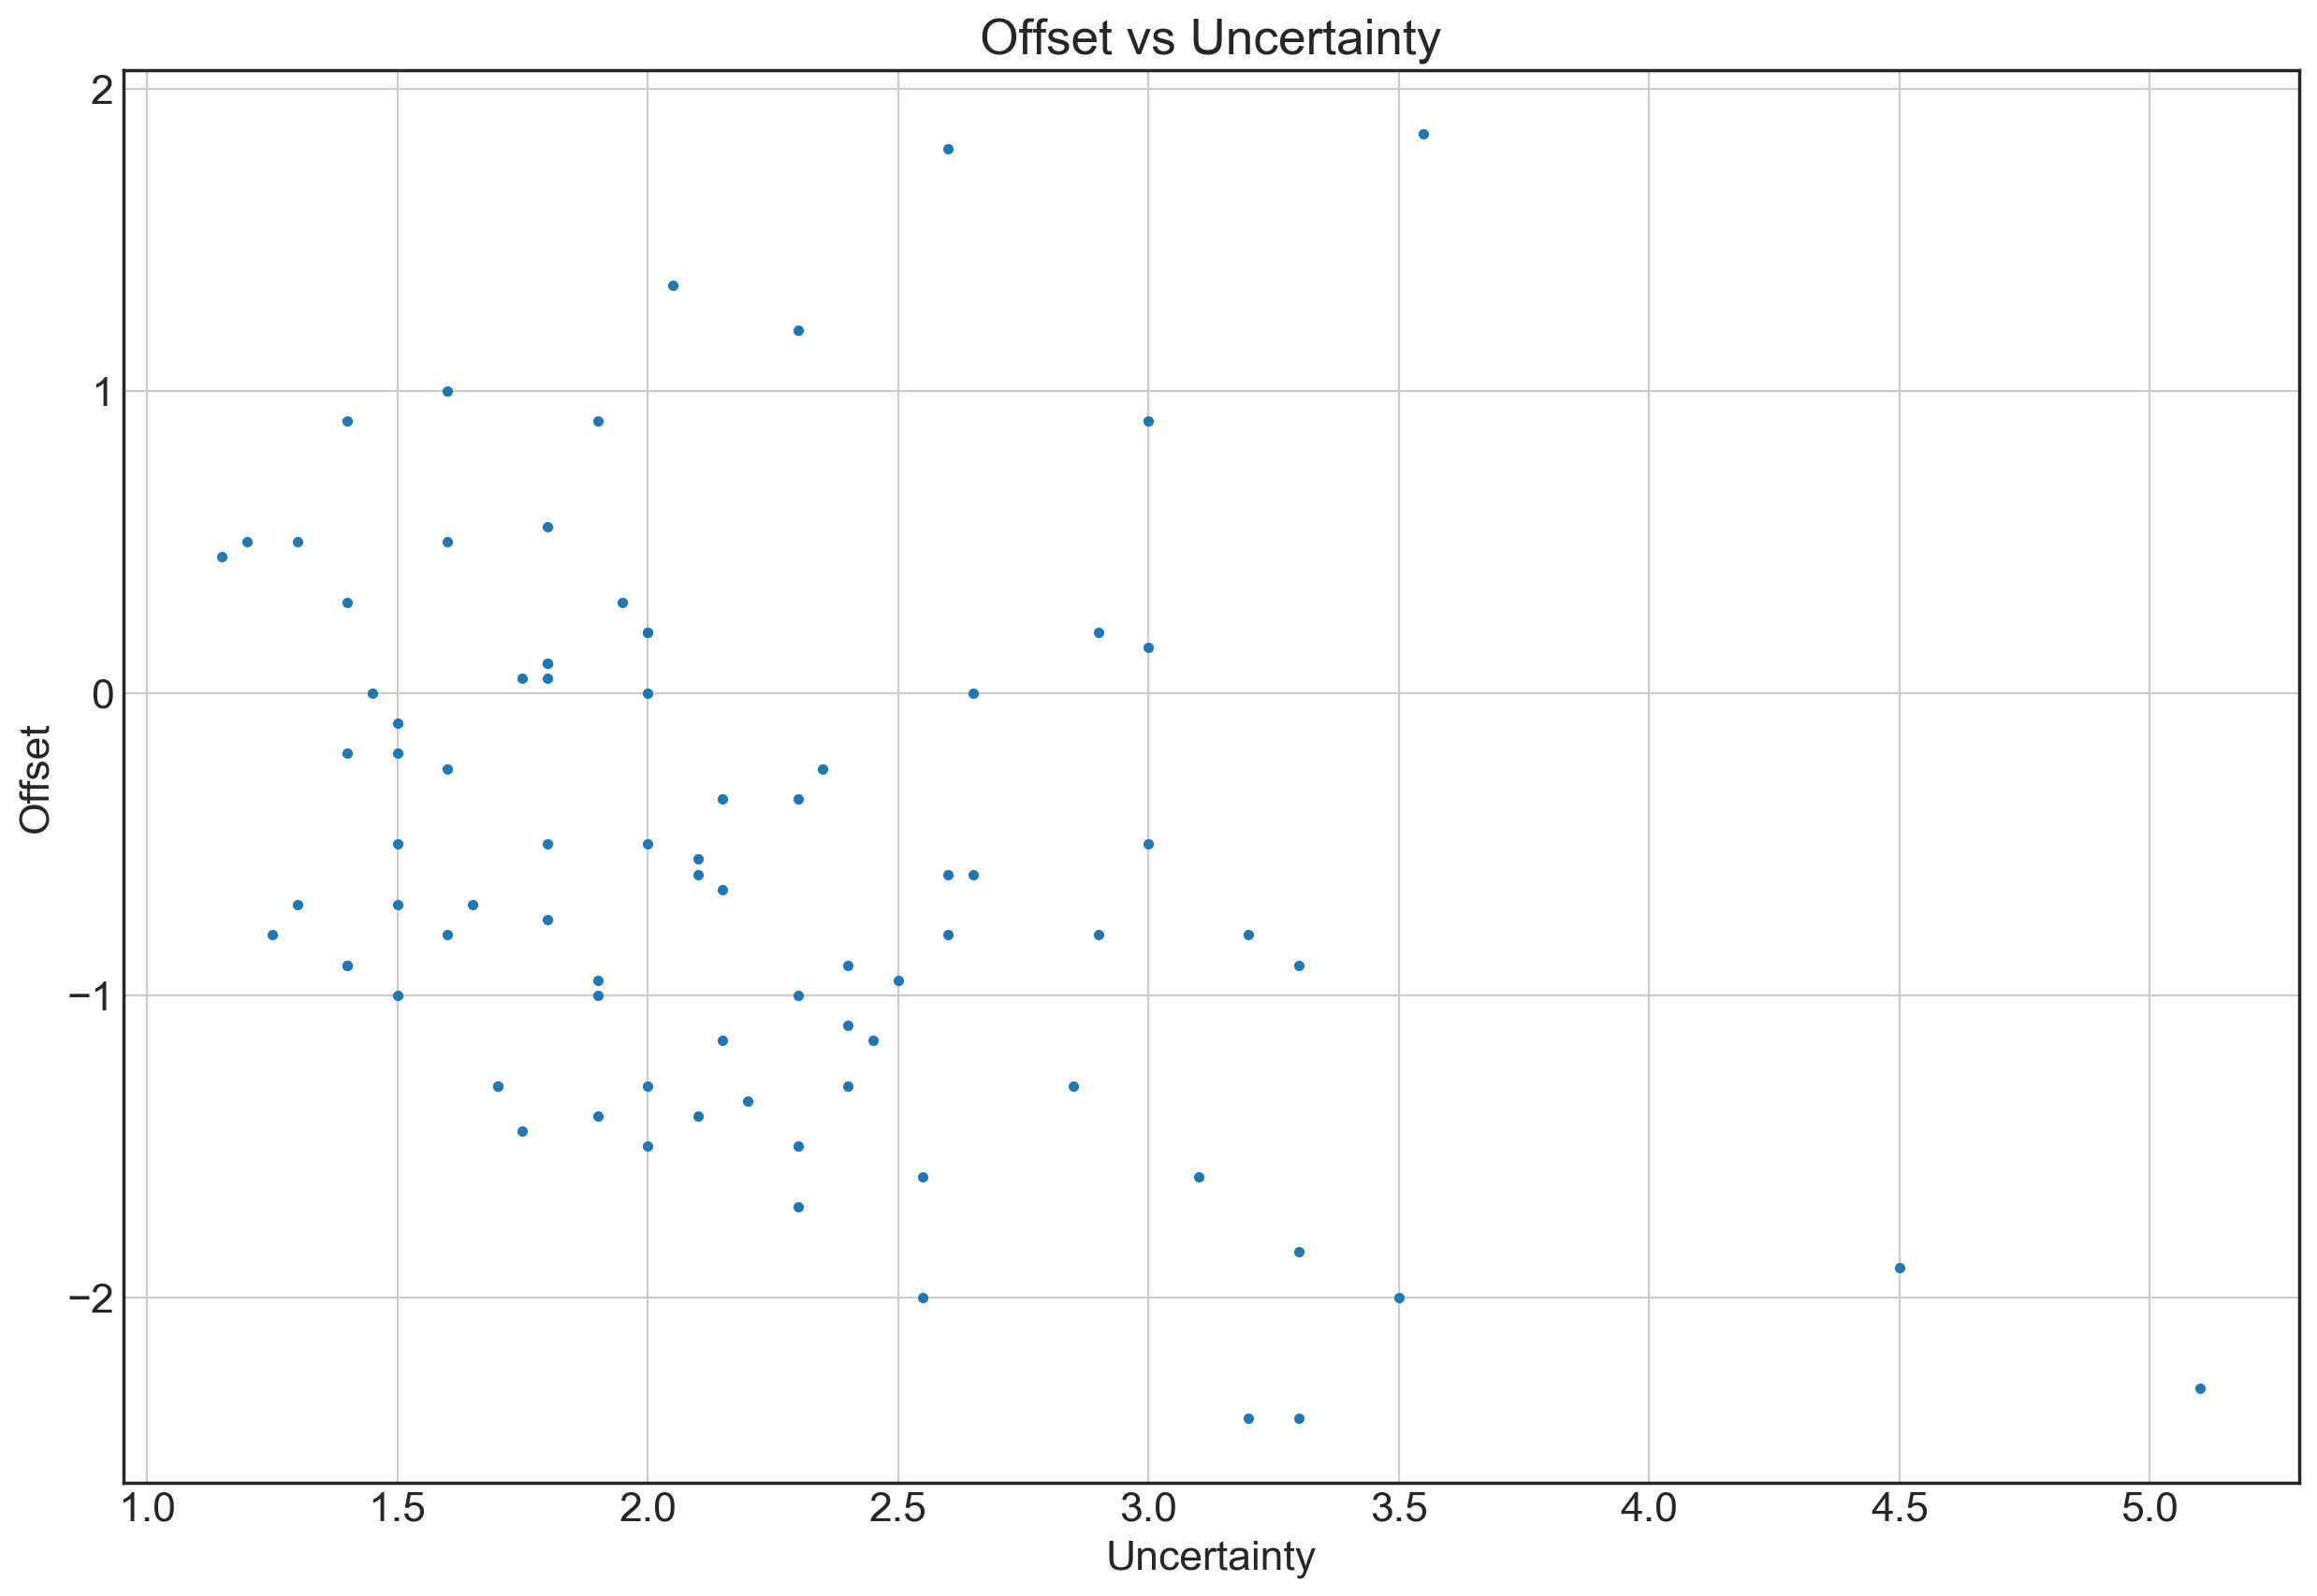

In [72]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(val_unc, val_offst, '.')
plt.title("Offset vs Uncertainty")
plt.ylabel("Offset")
plt.xlabel("Uncertainty")

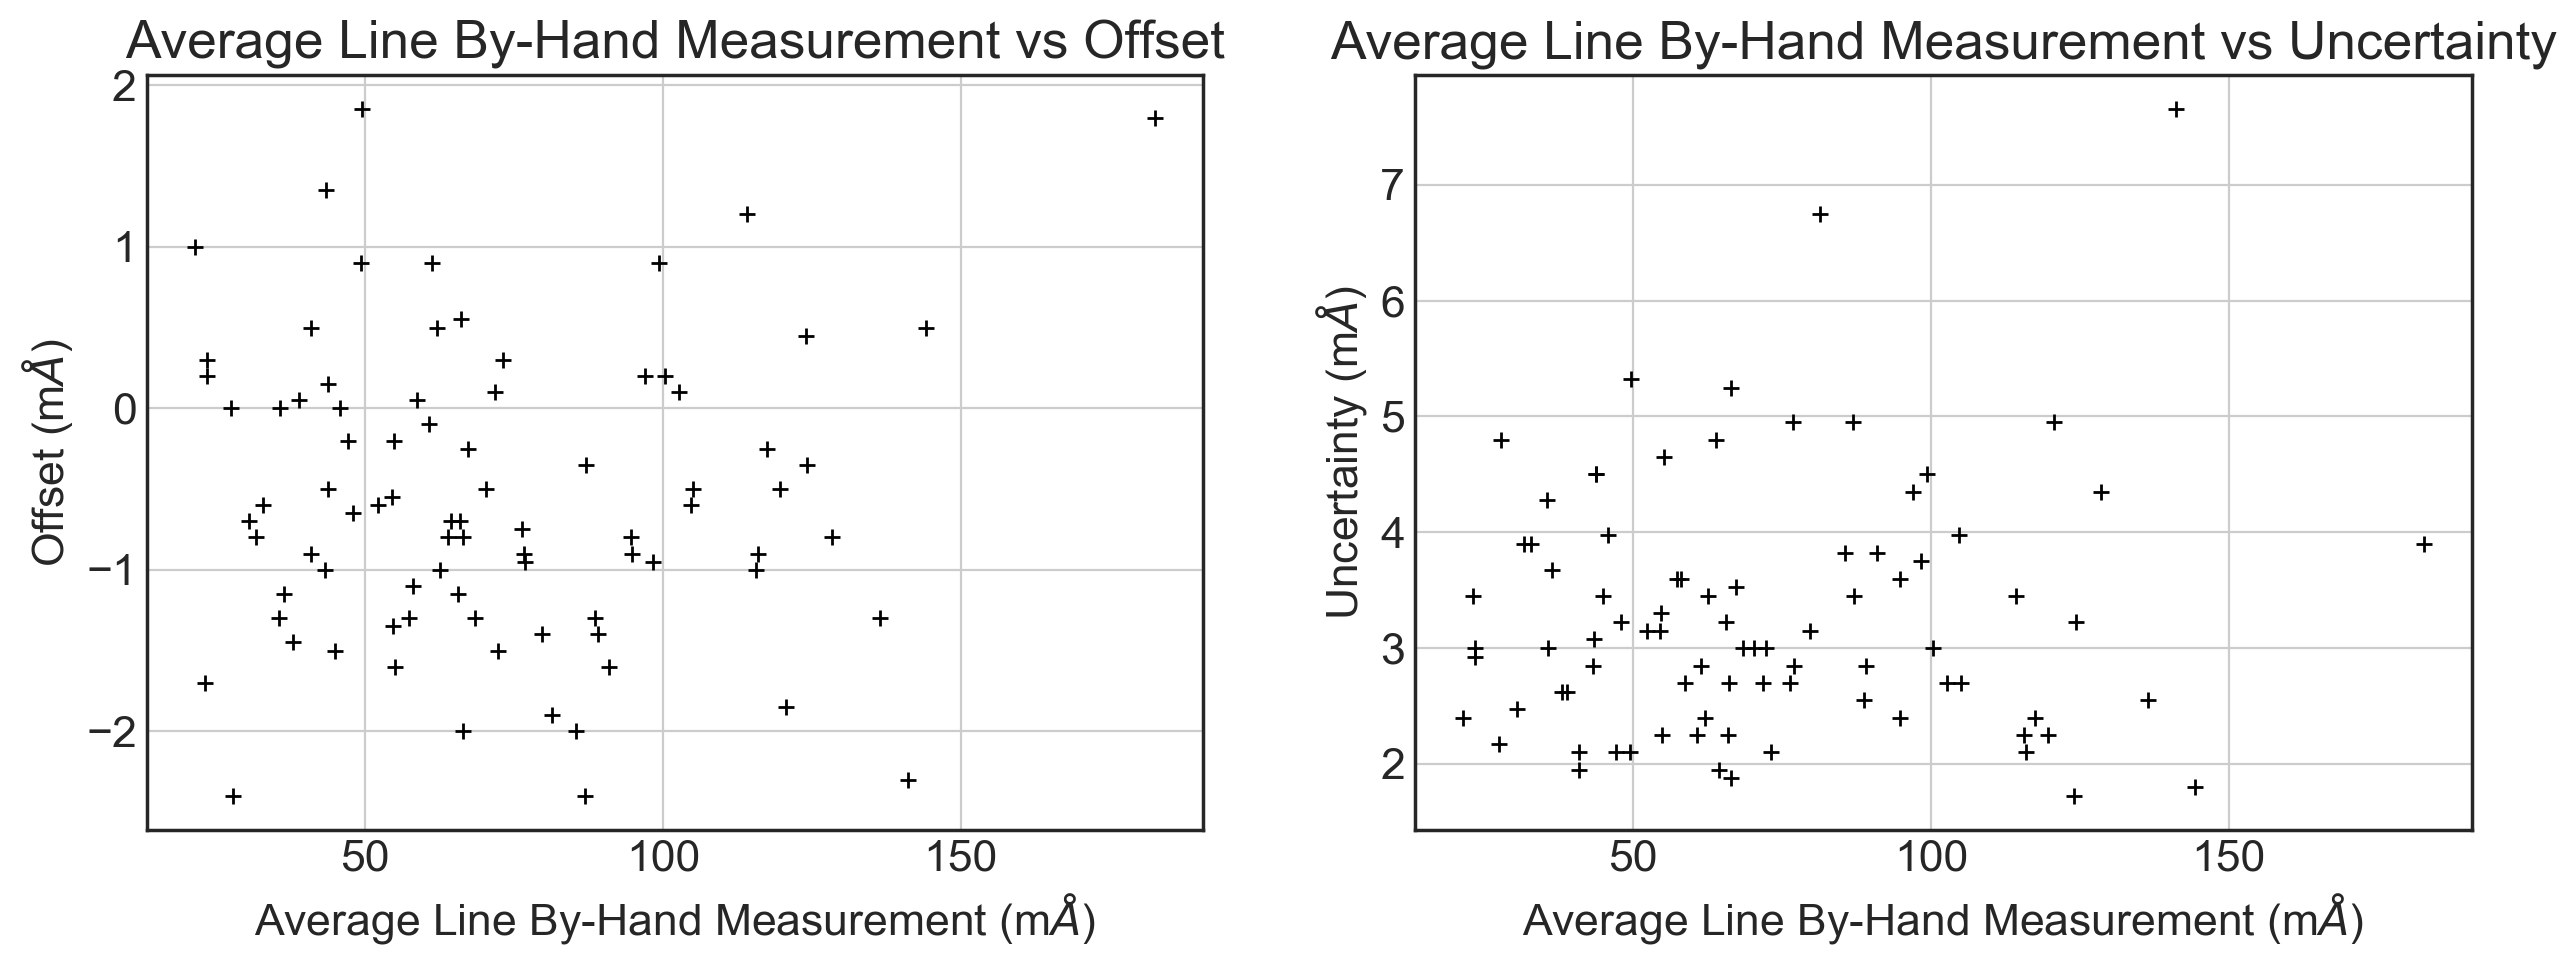

In [220]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.dpi = 200

ax1.plot(hand_meas, val_offst, '.',color='k',marker='+')
ax1.grid()
ax1.set_title("Average Line By-Hand Measurement vs Offset")
ax1.set_ylabel(r"Offset (m$\AA$)")
ax1.set_xlabel(r"Average Line By-Hand Measurement (m$\AA$)")

ax2.plot(hand_meas, val_unc, '.',color='k',marker='+')
ax2.grid()
ax2.set_title("Average Line By-Hand Measurement vs Uncertainty")
ax2.set_ylabel(r"Uncertainty (m$\AA$)")
ax2.set_xlabel(r"Average Line By-Hand Measurement (m$\AA$)")


plt.savefig("linestrength_corr.png")

#Journal?